# PANNs Revisados: Results From Saved Embeddings

Usa solo embeddings ya guardados en `outputs_03_panns_finetune_egfxset_unfreeze`.


# 1. Configuración

Este notebook replica el flujo del baseline de PANNs, pero insertando un bloque de **fine-tuning** más parecido al de MERT: además de una cabeza de proyección para embeddings, se permite **adaptación parcial del backbone** (últimos bloques convolucionales) para especializar el modelo al dominio EGFxSet.

Objetivos:

- Medir tiempo total de entrenamiento.
- Mantener protocolo de evaluación idéntico (Top‑1/Top‑5 por similitud coseno).
- Comparar con: (i) PANNs preentrenado, (ii) fine-tuning con cabeza congelando backbone, (iii) este experimento con backbone parcialmente entrenable.

In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torchaudio
import soundfile as sf

import re

from tqdm import tqdm
import transformers
from transformers import AutoModel

/opt/anaconda3/envs/mert310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Semilla y carpeta de salida

Fija semilla (reproducibilidad) y define el directorio de salida de este experimento (02).

In [2]:
import os, random
from pathlib import Path
import numpy as np
import torch

OUT_DIR_03 = Path("./outputs_03_panns_finetune_egfxset_unfreeze")
OUT_DIR_03.mkdir(parents=True, exist_ok=True)

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED)
print("OUT_DIR_03:", OUT_DIR_03.resolve())

OUT_DIR_03: /Users/dtenreiro/Documents/TFM/panns_inference/outputs_03_panns_finetune_egfxset_unfreeze


## 3. Dispositivo

Selecciona `mps/cuda/cpu` igual que en el baseline.

In [3]:
device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
device

if device == "cuda":
    print("CUDA device:", torch.cuda.get_device_name(0))
elif device == "mps":
    print("Apple Silicon MPS enabled")
else:
    print("CPU only")

Apple Silicon MPS enabled


## 4. Sincronización para benchmarks

Define `_sync()` para que las medidas de tiempo sean correctas en GPU/MPS.

In [4]:
import time
import numpy as np
import torch

def _sync():
    if device == "cuda" and torch.cuda.is_available():
        torch.cuda.synchronize()
    elif device == "mps" and hasattr(torch, "mps"):
        try:
            torch.mps.synchronize()
        except Exception:
            pass

def _summ(times_s, label=""):
    times = np.array(times_s, dtype=np.float64)
    return {
        "label": label,
        "n": int(times.size),
        "mean_ms": float(times.mean() * 1000),
        "p50_ms": float(np.percentile(times, 50) * 1000),
        "p95_ms": float(np.percentile(times, 95) * 1000),
        "min_ms": float(times.min() * 1000),
        "max_ms": float(times.max() * 1000),
        "runs_per_s": float(1.0 / times.mean()),
    }

# 2. Carga del índice del dataset

Reutiliza el `egfxset_index.csv` generado por el baseline de PANNs para mantener el **mismo orden** y metadatos.

In [5]:
import pandas as pd
from pathlib import Path

INDEX_CSV_PATH = Path("../egfxset_index.csv")
assert INDEX_CSV_PATH.exists(), f"No encuentro {INDEX_CSV_PATH}. Ejecuta antes el notebook 01_PANNs_base_egfx."

df = pd.read_csv(INDEX_CSV_PATH)
print("Index:", df.shape)
df.head()

Index: (8947, 7)


,path,tone,pickup,tone_pickup,string,fret,midi_pitch
0,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,0,64
1,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,1,65
2,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,10,74
3,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,11,75
4,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,12,76


## 1. Configuración del objetivo de fine-tuning

La tarea de fine-tuning será **clasificar `tone_pickup`** (65 clases), como en el fine-tuning de MERT.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

LABEL_COL = "tone_pickup"

df["row_id"] = np.arange(len(df), dtype=int)

le = LabelEncoder()
df["label_id"] = le.fit_transform(df[LABEL_COL].astype(str))
N_CLASSES = len(le.classes_)
print("N_CLASSES:", N_CLASSES)

FT_TRAIN_INDEX_PATH = OUT_DIR_03 / "egfxset_index_used_train.csv"
FT_VAL_INDEX_PATH = OUT_DIR_03 / "egfxset_index_used_val.csv"

if FT_TRAIN_INDEX_PATH.exists() and FT_VAL_INDEX_PATH.exists():
    train_df = pd.read_csv(FT_TRAIN_INDEX_PATH)
    val_df = pd.read_csv(FT_VAL_INDEX_PATH)
    split_source = f"saved split ({FT_TRAIN_INDEX_PATH.name}, {FT_VAL_INDEX_PATH.name})"
else:
    train_df, val_df = train_test_split(
        df,
        test_size=0.2,
        random_state=SEED,
        stratify=df["label_id"]
    )
    split_source = "recomputed split (seeded stratified 80/20)"

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

assert "row_id" in train_df.columns and "row_id" in val_df.columns, (
    "Falta 'row_id' en train/val index. Revisa los CSV guardados del fine-tune."
)

train_idx = train_df["row_id"].to_numpy(dtype=int)
val_idx = val_df["row_id"].to_numpy(dtype=int)

print("Split source:", split_source)
print("Train:", train_df.shape, "| Val:", val_df.shape)
print("train_idx:", train_idx.shape, "| val_idx:", val_idx.shape)


N_CLASSES: 65
Split source: saved split (egfxset_index_used_train.csv, egfxset_index_used_val.csv)
Train: (7157, 9) | Val: (1790, 9)
train_idx: (7157,) | val_idx: (1790,)


# 6. Evaluación (Top-1 / Top-5)

Evalúa retrieval con similitud coseno en **esquema Val -> Train**.


## Evaluación Top-1 / Top-5 (retrieval Val -> Train)

Se evalúa **solo en validación consultando contra train**:
- Normalizamos L2 embeddings de train y val.
- Calculamos similitud coseno `S = X_val @ X_train.T`.
- Computamos Top-1 y Top-5 en validación con vecinos de train.


In [7]:
import numpy as np
import pandas as pd
from pathlib import Path

def l2_normalize(X: np.ndarray, eps: float = 1e-9) -> np.ndarray:
    n = np.linalg.norm(X, axis=1, keepdims=True)
    return X / (n + eps)

labels_all = df["tone_pickup"].astype(str).to_numpy()
y_train = labels_all[train_idx]
y_val = labels_all[val_idx]

# Embedding objetivo del fine-tune (único válido para resultados)
best_proj_file = OUT_DIR_03 / "embeddings_panns_ft_proj_global_proj.npy"
assert best_proj_file.exists(), (
    f"No encuentro {best_proj_file}. Ejecuta el notebook 03 para generar embeddings proyectados."
)
print("Using projected embedding:", best_proj_file.name)

X = np.memmap(best_proj_file, dtype=np.float32, mode="r").reshape(len(df), -1)
X = l2_normalize(X)

Xt = X[train_idx]  # (N_train, D)
Xv = X[val_idx]    # (N_val, D)

S = Xv @ Xt.T

# Top-1
nn1 = np.argmax(S, axis=1)
top1 = (y_train[nn1] == y_val).mean()

# Top-5
k = min(5, Xt.shape[0])
nnk = np.argpartition(-S, kth=k-1, axis=1)[:, :k]
top5 = np.array([y_val[i] in y_train[nnk[i]] for i in range(len(y_val))]).mean()

res_df = pd.DataFrame([
    {
        "file": best_proj_file.name,
        "dim": Xv.shape[1],
        "top1": float(top1),
        "top5": float(top5),
        "eval_set": "val->train",
        "n_train": int(len(train_idx)),
        "n_val": int(len(val_idx)),
    }
])
res_df


Using projected embedding: embeddings_panns_ft_proj_global_proj.npy


,file,dim,top1,top5,eval_set,n_train,n_val
0,embeddings_panns_ft_proj_global_proj.npy,256,0.951397,0.969832,val->train,7157,1790


## 1. Baseline de azar

Calcula `chance = 1/C` y cuántas veces mejora el modelo sobre el azar.

In [8]:
chance = 1.0 / N_CLASSES

res_df_eval = res_df.copy()
res_df_eval["chance"] = chance
res_df_eval["top1_vs_chance"] = res_df_eval["top1"] / chance

res_df_eval = res_df_eval.sort_values(
    ["top1", "top5"], ascending=False
)

res_df_eval.head(10)

,file,dim,top1,top5,eval_set,n_train,n_val,chance,top1_vs_chance
0,embeddings_panns_ft_proj_global_proj.npy,256,0.951397,0.969832,val->train,7157,1790,0.015385,61.840782


## 2. Gráfico Top-1 / Top-5 (configuración única)

Este notebook evalúa una sola configuración (embedding proyectado), así que se muestra un único resumen.


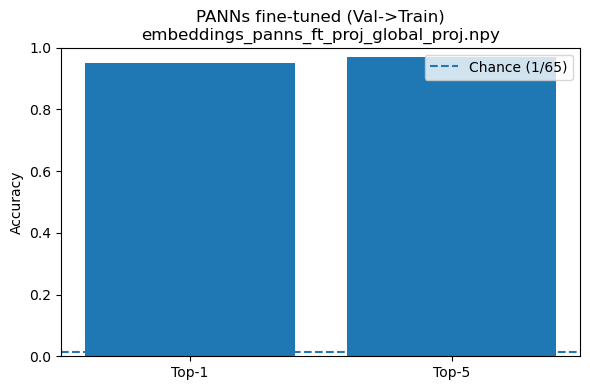

In [9]:
import matplotlib.pyplot as plt

row = res_df_eval.iloc[0]

top1 = float(row["top1"])
top5 = float(row["top5"])
chance = float(row["chance"])
label = row["file"]

plt.figure(figsize=(6, 4))
plt.bar(["Top-1", "Top-5"], [top1, top5])
plt.axhline(chance, linestyle="--", label=f"Chance (1/{int(round(1/chance))})")
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title(f"PANNs fine-tuned (Val->Train)\n{label}")
plt.legend()
plt.tight_layout()
plt.show()

## 3. Matriz de confusión (Val -> Train)

Construye la matriz de confusión Top-1 en validación, prediciendo con vecinos de train.


Best embedding (Val->Train): embeddings_panns_ft_proj_global_proj.npy


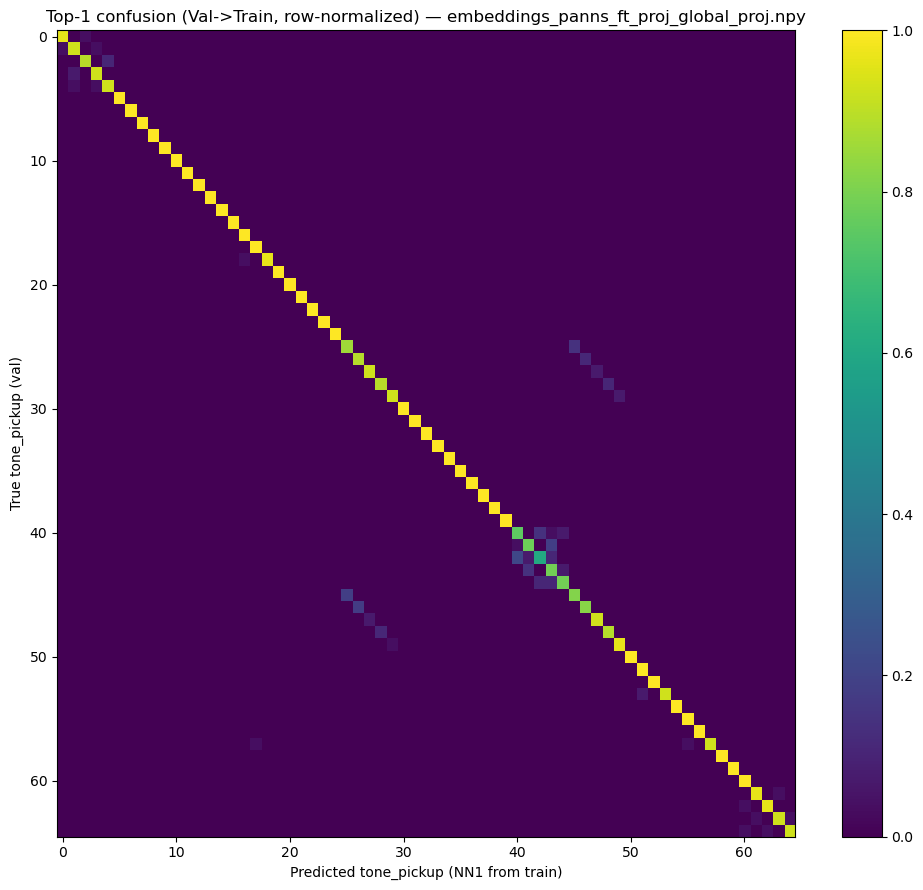

,row_0,col_0,count
0,RAT__Middle,RAT__Bridge,6
1,RAT__Bridge-Middle,RAT__Middle-Neck,5
2,Spring Reverb__Bridge,Hall Reverb__Bridge,5
3,Spring Reverb__Bridge-Middle,Hall Reverb__Bridge-Middle,5
4,RAT__Middle-Neck,RAT__Bridge-Middle,4
5,Hall Reverb__Bridge,Spring Reverb__Bridge,4
6,RAT__Bridge,RAT__Middle,4
7,Hall Reverb__Bridge-Middle,Spring Reverb__Bridge-Middle,3
8,RAT__Neck,RAT__Middle-Neck,3
9,BluesDriver__Middle,BluesDriver__Neck,3


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

best_file = res_df.iloc[0]["file"]
best_path = OUT_DIR_03 / best_file
print("Best embedding (Val->Train):", best_file)

X = np.memmap(best_path, dtype=np.float32, mode="r").reshape(len(df), -1)
X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)

labels_all = df["tone_pickup"].astype(str).to_numpy()
y_train = labels_all[train_idx]
y_true = labels_all[val_idx]

Xt = X[train_idx]
Xv = X[val_idx]

S = Xv @ Xt.T
nn1 = np.argmax(S, axis=1)
y_pred = y_train[nn1]

cm = pd.crosstab(y_true, y_pred)
cm = cm.reindex(index=sorted(cm.index), columns=sorted(cm.columns), fill_value=0)
cm_norm = cm.div(cm.sum(axis=1).replace(0, 1), axis=0)

plt.figure(figsize=(10, 9))
plt.imshow(cm_norm.to_numpy(), aspect="auto")
plt.title(f"Top-1 confusion (Val->Train, row-normalized) — {best_file}")
plt.xlabel("Predicted tone_pickup (NN1 from train)")
plt.ylabel("True tone_pickup (val)")
plt.colorbar()
plt.tight_layout()
plt.show()

cm_off = cm.copy()
for k in cm_off.index:
    if k in cm_off.columns:
        cm_off.loc[k, k] = 0

top_conf = (
    cm_off.stack()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
    .rename(columns={"level_0": "true", "level_1": "pred", 0: "count"})
)
top_conf


## 4. Tabla resumen de resultados

Resumen del único embedding evaluado en esquema Val -> Train.


In [11]:
tabla = res_df_eval.copy()

tabla["Configuración"] = tabla["file"]
tabla["Modelo"] = "PANNs CNN14 fine-tuned"
tabla["Capas usadas"] = "Global (interno)"
tabla["Pooling de capas"] = "Global pooling (modelo)"
tabla["Dimensión"] = tabla["dim"]
tabla["Top-1"] = tabla["top1"].round(3)
tabla["Top-5"] = tabla["top5"].round(3)
tabla["Veces mejor que azar"] = tabla["top1_vs_chance"].round(1)

tabla_final = tabla[
    ["Configuración", "Modelo", "Capas usadas", "Pooling de capas",
     "Dimensión", "Top-1", "Top-5", "Veces mejor que azar"]
].sort_values("Top-1", ascending=False)

tabla_final

,Configuración,Modelo,Capas usadas,Pooling de capas,Dimensión,Top-1,Top-5,Veces mejor que azar
0,embeddings_panns_ft_proj_global_proj.npy,PANNs CNN14 fine-tuned,Global (interno),Global pooling (modelo),256,0.951,0.97,61.8


# 7. t-SNE (mismos gráficos y leyendas)

Repite los dos t-SNE del baseline:
- Uno global coloreado por `tone_pickup` (sin leyenda detallada)
- Subplots por `tone`, coloreando por `pickup` con **leyenda correcta**

Usando best_file: embeddings_panns_ft_proj_global_proj.npy | Val->Train top1=0.9514 | top5=0.9698


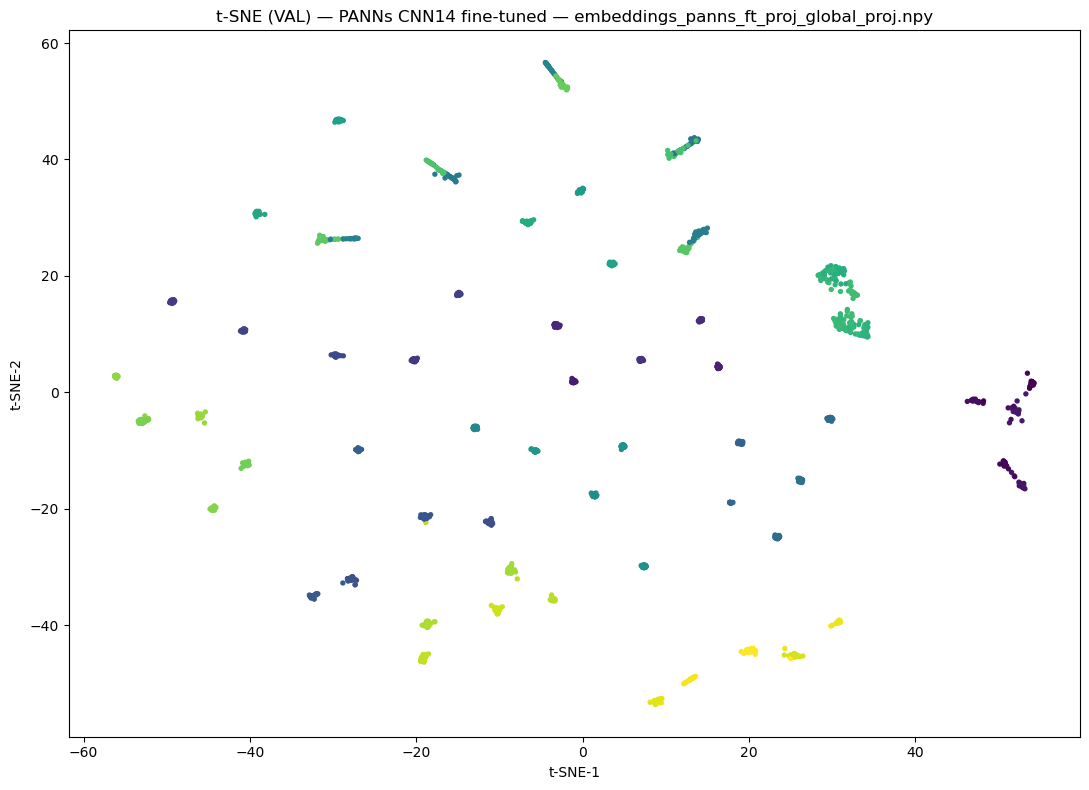

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

best_file = res_df.iloc[0]["file"]
best_path = OUT_DIR_03 / best_file
best_top1 = float(res_df.iloc[0]["top1"])
best_top5 = float(res_df.iloc[0]["top5"])

print(f"Usando best_file: {best_file} | Val->Train top1={best_top1:.4f} | top5={best_top5:.4f}")

X = np.memmap(best_path, dtype=np.float32, mode="r").reshape(len(df), -1)
labels_all = df["tone_pickup"].astype(str).to_numpy()

X = X[val_idx]
labels = labels_all[val_idx]

X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)

pca_dim = min(50, X.shape[1])
X_pca = PCA(n_components=pca_dim, random_state=42).fit_transform(X)

N = X_pca.shape[0]
perplexity = max(5, min(30, (N - 1) // 3))

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    init="pca",
    learning_rate="auto",
    random_state=42,
)
Z = tsne.fit_transform(X_pca)

uniq = sorted(set(labels.tolist()))
lab2i = {u:i for i,u in enumerate(uniq)}
c = np.array([lab2i[x] for x in labels], dtype=int)

plt.figure(figsize=(11, 8))
plt.scatter(Z[:, 0], Z[:, 1], c=c, s=8)
plt.title(f"t-SNE (VAL) — PANNs CNN14 fine-tuned — {best_file}")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.tight_layout()
plt.show()

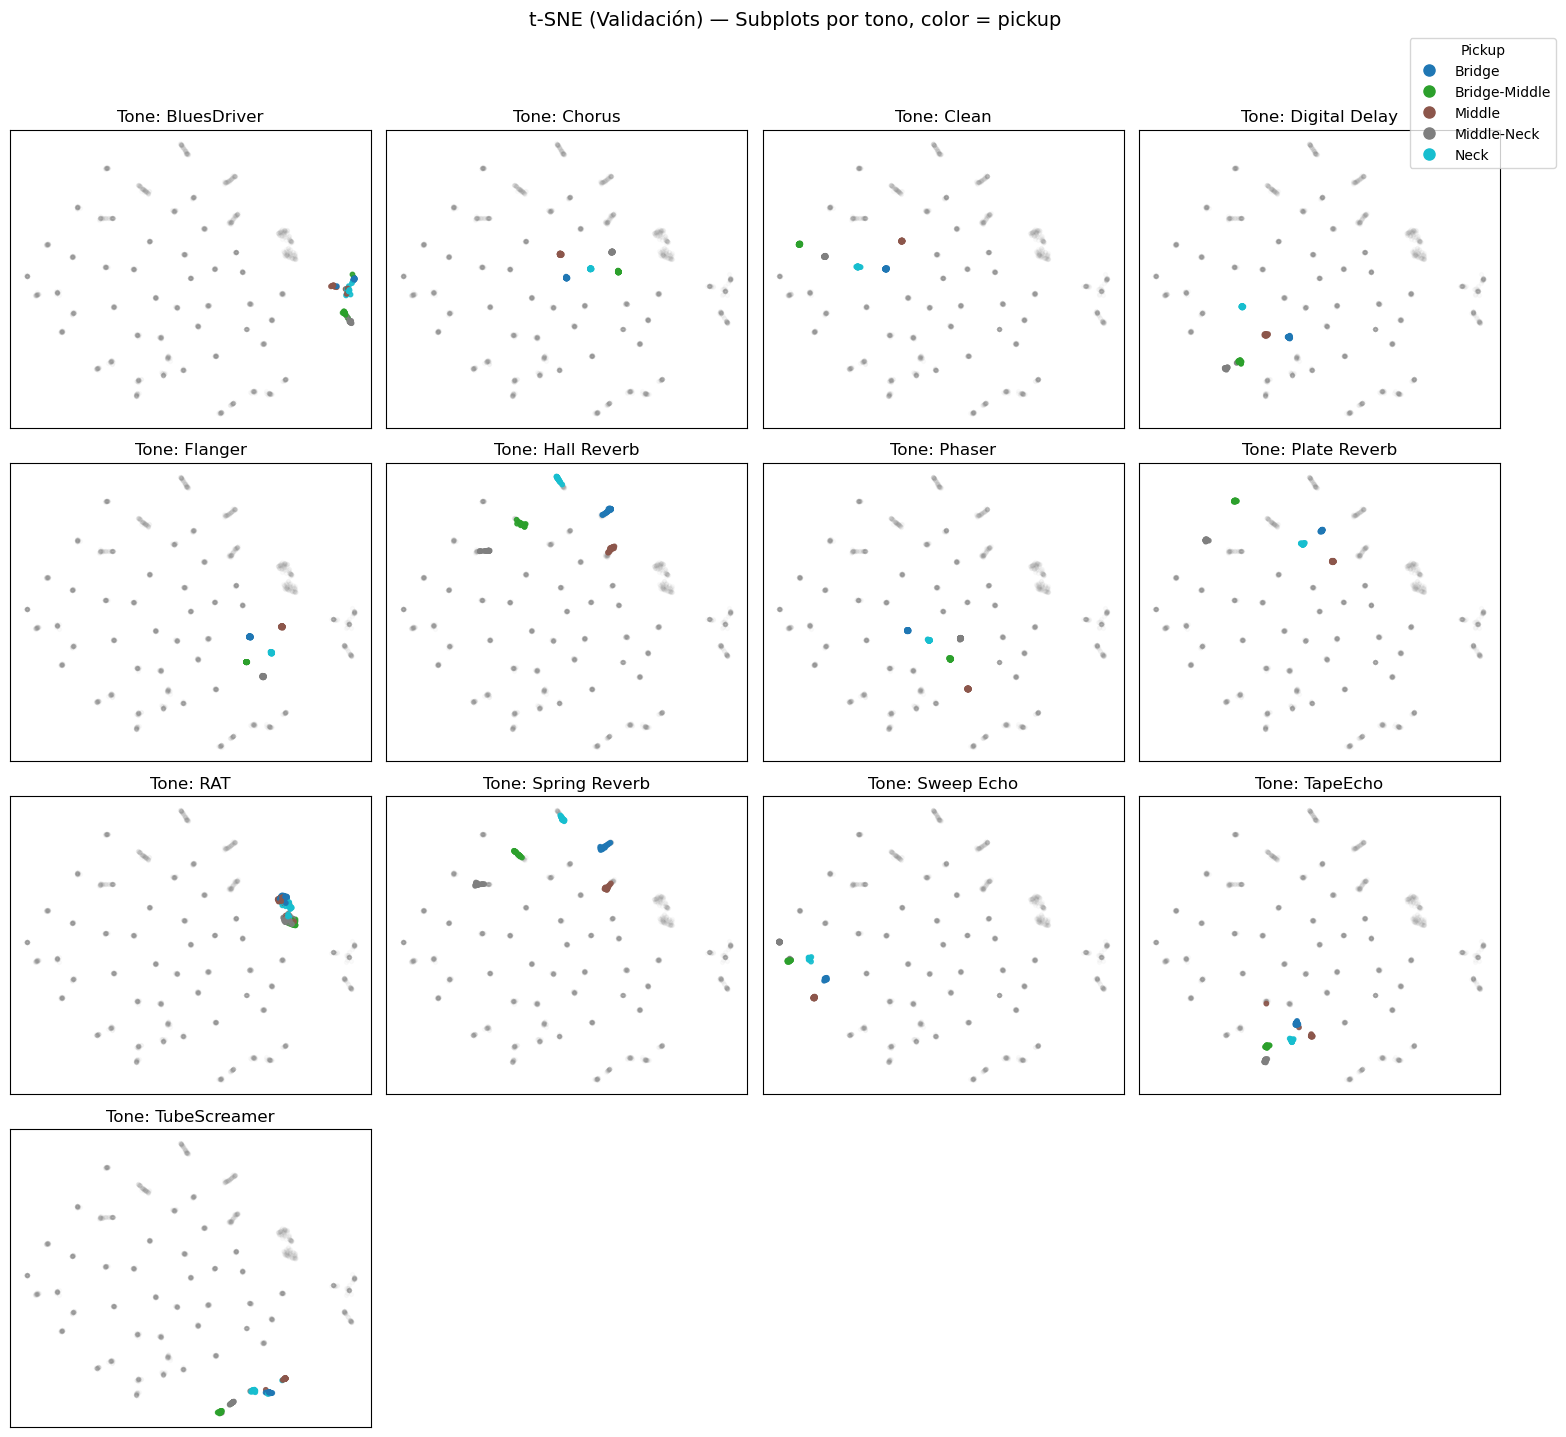

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

if "Z_val" in globals():
    Z_used = Z_val
elif "Z" in globals():
    Z_used = Z
else:
    raise NameError("No existe ni Z_val ni Z. Calcula el t-SNE antes (variable típica: Z).")

if "val_idx" not in globals():
    raise NameError("No existe val_idx. Necesito val_idx para alinear df con el t-SNE de validación.")

df_val = df.iloc[val_idx].copy().reset_index(drop=True)

assert Z_used.shape[0] == len(df_val), (
    f"El t-SNE tiene {Z_used.shape[0]} filas pero df_val tiene {len(df_val)}.\n"
    "Z debe corresponder a validación (mismo orden que val_idx)."
)

pickups = sorted(df_val["pickup"].astype(str).unique().tolist())
pickup_to_id = {p: i for i, p in enumerate(pickups)}
pickup_ids = df_val["pickup"].astype(str).map(pickup_to_id).to_numpy()

from matplotlib import colormaps
cmap = colormaps.get_cmap("tab10").resampled(max(len(pickups), 1))

tones = sorted(df_val["tone"].astype(str).unique().tolist())
n_tones = len(tones)

ncols = int(np.ceil(np.sqrt(n_tones)))
nrows = int(np.ceil(n_tones / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.6*nrows), squeeze=False)
axes = axes.ravel()

tone_arr = df_val["tone"].astype(str).to_numpy()

for i, t in enumerate(tones):
    ax = axes[i]
    m = (tone_arr == t)

    # Fondo gris
    ax.scatter(Z_used[~m, 0], Z_used[~m, 1], s=8, alpha=0.03, color="grey")

    # Tono actual (color = pickup)
    ax.scatter(
        Z_used[m, 0], Z_used[m, 1],
        c=pickup_ids[m],
        cmap=cmap,
        s=10, alpha=0.9,
        vmin=0, vmax=max(len(pickups)-1, 0)
    )

    ax.set_title(f"Tone: {t}")
    ax.set_xticks([]); ax.set_yticks([])

for j in range(n_tones, len(axes)):
    axes[j].axis("off")

legend_handles = [
    Line2D([0], [0], marker='o', linestyle='',
           markerfacecolor=cmap(i), markeredgecolor=cmap(i),
           markersize=8, label=p)
    for i, p in enumerate(pickups)
]

fig.legend(
    handles=legend_handles,
    title="Pickup",
    loc="upper right",
    bbox_to_anchor=(0.98, 0.98),
    frameon=True
)

fig.suptitle("t-SNE (Validación) — Subplots por tono, color = pickup",
             y=0.995, fontsize=14)

# Dejar espacio arriba para la leyenda
plt.tight_layout(rect=[0, 0, 0.95, 0.96])

plt.show()